<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение модели прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Общие-выводы-и-рекомендации" data-toc-modified-id="Общие-выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы и рекомендации</a></span></li></ul></div>

# Прогнозирование оттока клиентов сети фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

Задача — провести анализ и подготовить план действий по удержанию клиентов.

**Цели исследования:**

1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. проанализировать основные признаки, наиболее сильно влияющие на отток;
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   - выделить целевые группы клиентов;
   - предложить меры по снижению оттока;
   - определить другие особенности взаимодействия с клиентами.

<div style="border:solid black 1px; padding: 20px">

**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц:

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
- `Churn` — факт оттока в текущем месяце.
    
</div>    

In [1]:
# импортируем необходимые библиотеки
import pandas as pd              
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

## Обзор данных

In [2]:
# чтение данных из файла и сохранение в data
data = pd.read_csv('/datasets/gym_churn.csv')

data.info()             # получение общей информации о данных
display(data.head(10))  # вывод первых 10 строк

print('Количество явных дубликатов ', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Количество явных дубликатов  0


In [3]:
# приведение наименования столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

<div style="border:solid green 3px; padding: 20px">
    
**Промежуточный вывод**

Датафрейм `data` содержит 4000 строк и 14 столбцов. Встречаюшиеся типы данных - целые и вещественные числа, типы данных столбцов соответствуют их содержанию.
    
Видим, что явные дубликаты и пропущенные значения отсутствуют. Наименования столбцов привели к нижнему регистру.  
    
</div>

## Исследовательский анализ данных

<div class="alert alert-block alert-info">
<font color='Black'>
    
Изучим средние значения и стандартные отклонения признаков.
    
</font>
</div>

In [4]:
display(data.describe().T) # вывод описательной статистики

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


<div class="alert alert-block alert-info">
<font color='Black'>

На основе описательной статистики можно сделать следующие выводы:    
- доля мужчин и доля женщин в выборке примерно равны (`gender`);
- большинство клиентов в выборке проживает или работает рядом с фитнес-центром (`near_location`);
- примерно половина клиентов в выборке является сотрудником компании-партнера (`partner`);
- около 30% клиентов в выборке купили абонемент в рамках акции "приведи друга"(`promo_friends`);
- 90% клиентов в выборке предоставили контактный телефон (`phone`);
- 75% клиентов в выборке имеют действующий абонемент продолжительностью не более 6 месяцев (`contract_period`);
- 40% клиентов в выборке посещали групповые занятия (`group_visits`);
- средний возраст клиентов в выборке составил 29,18, что практически соответствует медианному значению возраста 29 (`age`);
- среднее значение суммарной выручки от других услуг фитнес-центра признака составило 146,94, медианное значение — 136,22 (`avg_additional_charges_total`);
- среднее значение срока до окончания текущего действующего абонемента составило 4,32, медианное значение — 1 месяц, распределение `month_to_end_contract` похоже на распределение признака `contract_period`;    
- среднее значение числа месяцев с момента первого обращения в фитнес-центр признака составило 3,72, медианное значение 3 месяца, максимальное  составило 31 (`lifetime`);
- среднее значение средней частоты посещений в неделю за все время с начала действия абонемента  составило 1,88, медианное значение 1,83 (`avg_class_frequency_total`);
- среднее значение средней частоты посещений в неделю за предыдущий месяц составило 1,77, медианное значение — 1,72  (`avg_class_frequency_current_month`);
- около 27%  клиентов в выборке перестали посещать фитнес-центр в текущем месяце (`churn`).
    
</font>
</div>

<div class="alert alert-block alert-info">
<font color='Black'>
    
Изучим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.
    
</font>
</div>

In [5]:
# выведем средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
data.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


<div class="alert alert-block alert-info">
<font color='Black'>
    
На основе сравнения средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался — можно сделать следующие предположения о влиянии признаков на факт оттока:
    
- пол клиента и наличие контактного телефона практически не оказывают влияния на факт оттока;
- близость расположения фитнес-центра, работа в компании-партнере, участие в акции "приведи друга", посещение групповых занятий могут оказывать влияние на факт оттока;
- чем более длительный абонемент приобретает клиент, тем меньше вероятность оттока;
- средний возраст клиентов, ушедших в отток, меньше среднего возраста оставшихся клиентов;
- оставшиеся клиенты в среднем тратят больше на дополнительные услуги, чем ушедшие в отток;
- оставшиеся клиенты в среднем в неделю посещают фитнес-центр чаще и дольше, чем ушедшие в отток.     
    
    
</font>
</div>

<div class="alert alert-block alert-info">
<font color='Black'>
    
Построим столбчатые гистограммы распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).
    
</font>
</div>

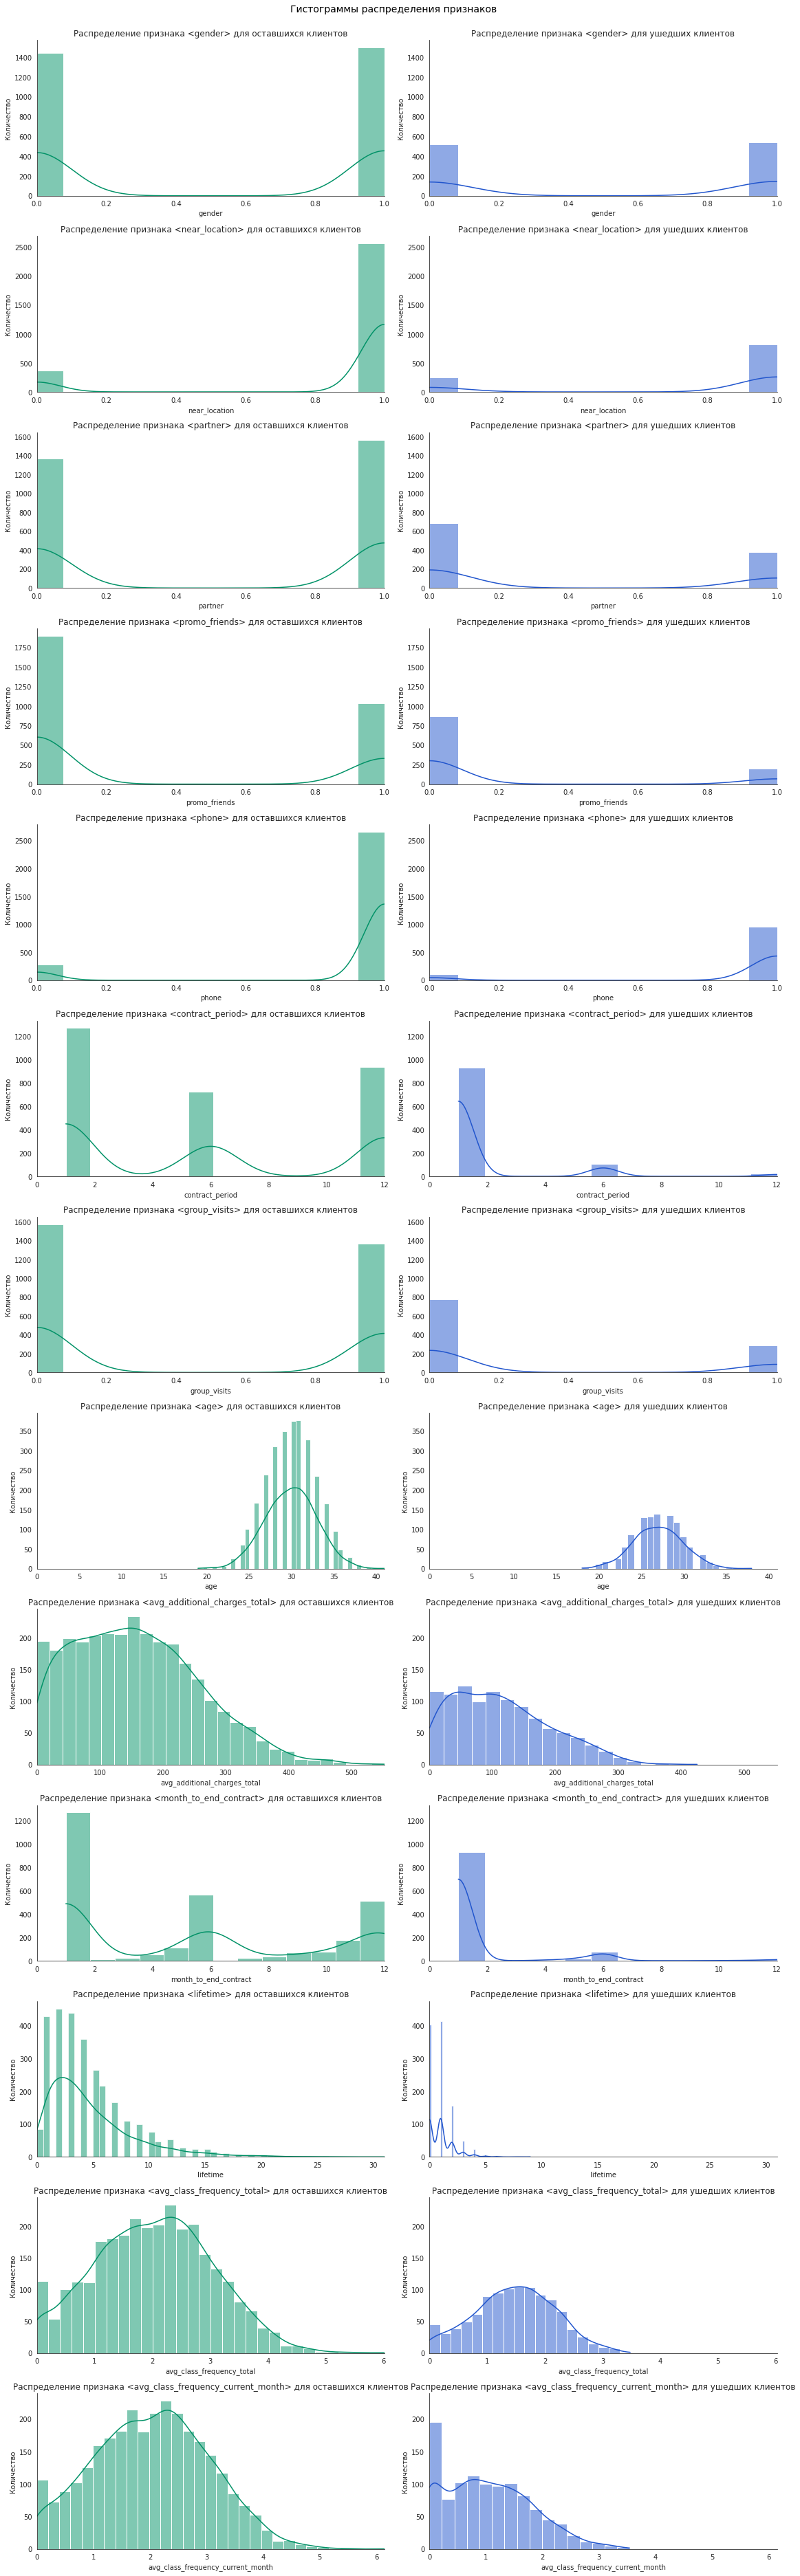

In [6]:
# построим гистрограммы распределения признаков для тех, кто ушёл (отток)
# и тех, кто остался (не попали в отток) 

number_of_graph_in_row = 2
number_of_graph_in_column = 13

plt.figure(figsize=(number_of_graph_in_row*8,number_of_graph_in_column*4))
plt.suptitle('Гистограммы распределения признаков', y = 1.0, fontsize = 14)

sns.set_style(style='white')

i = 1

for column in data.columns[:-1]:
    
    values_1=data[data['churn'] != 1][column]
    values_2=data[data['churn'] == 1][column]
    
    # строим гистограмму для признака column для тех, кто остался (не попали в отток) 
    ax_1 = plt.subplot(number_of_graph_in_column, number_of_graph_in_row, i)
    sns.histplot(data=values_1, kde=True, color='#019267', ax=ax_1)
    plt.xlim(0, max(max(values_1),max(values_2)))
    plt.ylabel('Количество')
    plt.title('Распределение признака <{}> для оставшихся клиентов'.format(column))

    # строим гистограмму для признака column для тех, кто ушёл (отток) 
    ax_2 = plt.subplot(number_of_graph_in_column, number_of_graph_in_row, i+1, sharey=ax_1)
    sns.histplot(data=values_2, kde=True, color='#2155CD', ax=ax_2)
    plt.xlim(0, max(max(values_1),max(values_2)))
    plt.ylabel('Количество')
    plt.title('Распределение признака <{}> для ушедших клиентов'.format(column))
    
    sns.despine()
    
    i = i + number_of_graph_in_row 

plt.tight_layout()    
plt.show()

<div class="alert alert-block alert-info">
<font color='Black'>
    
На основе гистограмм распределения признаков можно предположить, что группа клиентов, ушедших в отток, обладает следующими характеристиками:

- пол не влияет на факт оттока, примерно поровну уходят как мужчины, так и женщины;
- дальность расположения фитнес-центра не является основной причиной, видим, что большинство ушедших клиентов в выборке проживали или работали рядом с фитнес-центром;
- в основном ушедшие клиенты приобретают абонемент длительностью 1 месяц;
- срок до конца абонемента большинства ушедших клиентов составляет 1 месяц;
- в течение предыдущего месяца большинство ушедших клиентов посещали фитнес-центр не более 2 раз в неделю;    
- распределение времени с момента первого обращения в фитнес-центр сосредоточено на значениях в 0-1 месяцев, далее видим резкий спад.    
    
</font>
</div>

<div class="alert alert-block alert-info">
<font color='Black'>
    
Построим матрицу корреляций признаков.
    
</font>
</div>

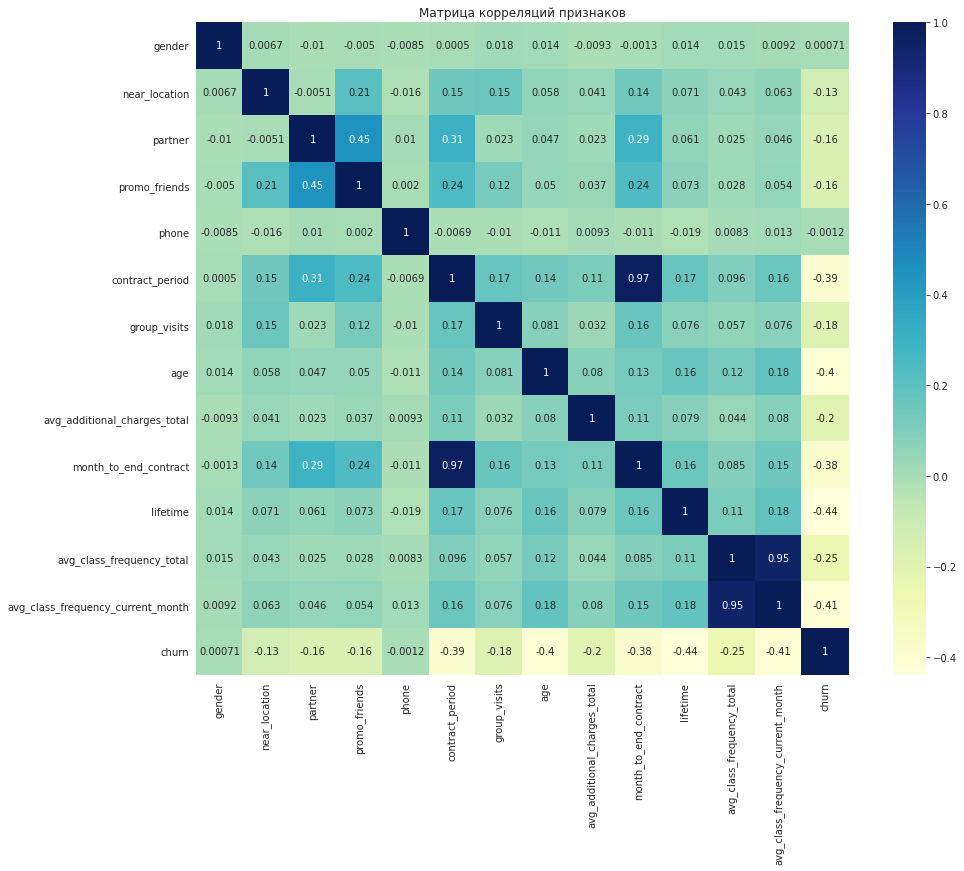

In [7]:
# построение матрицы корреляций признаков и ее вывод
# с помощью отображения тепловой карты
plt.figure(figsize=(16,12))
plt.title('Матрица корреляций признаков')
sns.heatmap(data.corr(), annot=True, square=True, cmap='YlGnBu')
plt.show()

<div class="alert alert-block alert-info">
<font color='Black'>
    
На визуализации матрицы корреляций видим, что сильно коррелирует между собой следующие признаки:

- срок до окончания текущего действующего абонемента (в месяцах) и длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента.
    
С целью получения лучшего результата применения моделей машинного обучения удалим по одному признаку из каждой пары сильно коррелирующих между собой признаков, тем самым устранив мультиколлинеарность.   
    
</font>
</div>

In [8]:
# удалим из датафрейма признаки month_to_end_contract и avg_class_frequency_total
drop_columns = ['month_to_end_contract', 'avg_class_frequency_total']
data_without_multicorr = data.copy()
data_without_multicorr = data_without_multicorr.drop(drop_columns, axis=1)

<div style="border:solid green 3px; padding: 20px">
    
**Промежуточный вывод**

Можно предположить, что группа клиентов, ушедших в отток, обладает следующими характеристиками:

- пол не влияет на факт оттока, примерно поровну уходят как мужчины, так и женщины;
- дальность расположения фитнес-центра не является основной причиной, видим, что большинство ушедших клиентов в выборке проживали или работали рядом с фитнес-центром;
- в основном ушедшие клиенты приобретают абонемент длительностью 1 месяц;
- срок до конца абонемента большинства ушедших клиентов составляет 1 месяц;
- в течение предыдущего месяца большинство ушедших клиентов посещали фитнес-центр не более 2 раз в неделю;    
- распределение времени с момента первого обращения в фитнес-центр сосредоточено на значениях в 0-1 месяцев, далее видим резкий спад. 

С целью получения лучшего результата применения моделей машинного обучения удалили по одному признаку из каждой пары сильно коррелирующих между собой признаков, тем самым устранив мультиколлинеарность.   
        
    
</div>

## Построение модели прогнозирования оттока клиентов

<div class="alert alert-block alert-info">
<font color='Black'>
    
Построим модель бинарной классификации клиентов, где целевой признак — бинарная величина — факт оттока клиента в следующем месяце.
Воспользуемся моделями:    
- логистической регрессией,
- случайным лесом.
    
Оценим метрики accuracy, precision и recall, F1 для обеих моделей на валидационной выборке.
    
</font>
</div>

In [9]:
# разделение данных на признаки - матрица X и целевую переменную - y
X = data_without_multicorr.drop('churn', axis = 1)
y = data_without_multicorr['churn']

# разделение модели на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    """функция, которая принимает на вход модель, обучает ее на входящих данных, 
       предсказывает значения целевой переменой для тестовых данных и 
       возвращает набор метрик для оценки качества модели.
 
       :param: m - класс для модели, X_train - матрица признаков для обучения, 
               y_train - вектор со значениями целевой переменной для обучающей выборки, 
               X_test - матрица признаков для тестирования, 
               y_test - вектор со значениями целевой переменной для тестовой выборки, 
       :return: возвращает объект типа Series  со значениями метрик accuracy, precision, recall, F1
    """
    model = m
    # обучение модели
    model.fit(X_train, y_train)
    # прогнозы для тестовой выборки
    y_pred = model.predict(X_test)
    result = pd.Series(data={'accuracy': round(accuracy_score(y_test, y_pred), 4),
                             'precision': round(precision_score(y_test, y_pred), 4),
                             'recall': round(recall_score(y_test, y_pred),4),
                             'F1': round(f1_score(y_test, y_pred),4)}, 
                       index=['accuracy', 'precision', 'recall', 'F1'])
    return result

In [11]:
# определим список из 2-х моделей: модели логистической регресии с солвером liblinear 
# и модели случайного леса
models = [
          LogisticRegression(solver='liblinear', random_state=0),
          RandomForestClassifier(random_state=0)
         ]

# определим список из наименований используемых моделей
models_name = ['LogisticRegression',
               'RandomForestClassifier']

In [12]:
# создадим пустой датафрейм для записи результата
result = pd.DataFrame()

i = 0 

for m in models:
    result[models_name[i]] = make_prediction(m, X_train, y_train, X_test, y_test)
    i =+1
    
print('Оценка метрик классификации на валидационной выборке')    
result

Оценка метрик классификации на валидационной выборке


,LogisticRegression,RandomForestClassifier
accuracy,0.8962,0.8962
precision,0.7919,0.8142
recall,0.7879,0.7525
F1,0.7899,0.7822


<div class="alert alert-block alert-info">
<font color='Black'>
    
Видим, что доля правильных ответов (accuracy) одинакова для двух моделей, точность (precision) немного лучше у алгоритма случайного леса, при этом полнота (recall) лучше у алгоритма логистической регрессии. 
    
Метрика recall показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Поскольку цель задачи - уменьшение оттока клиентов, то для нас важнее метрика полноты, т.е. важнее не пропустить уходящего клиента.
    
Recall демонстрирует способность алгоритма обнаруживать ушедших клиентов вообще, а precision — способность отличать ушедших клиентов от оставшихся. Так как precision и recall направлены на избежание противоположных рисков, воспользуемся сводной метрикой F1-score, учитывающей баланс между метриками. F1-score немного лучше у алгоритма логистической регрессии. 
    
Модель логистической регрессии показала более лучшие значения важных для нас метрик, поэтому для прогнозирования вероятности оттока можно использовать модель логистической регрессии.    
    
</font>
</div>

<div style="border:solid green 3px; padding: 20px">
    
**Промежуточный вывод**

Модель логистической регрессии показала более лучшие значения метрик, поэтому для прогнозирования вероятности оттока можно использовать модель логистической регрессии.  
    
</div>

## Кластеризация клиентов

<div class="alert alert-block alert-info">
<font color='Black'>
    
Проведем кластеризацию клиентов. 
    
Построим матрицу расстояний на стандартизованной матрице признаков и визуализируем ее с помощью дендрограммы.    
</font>
</div>

In [13]:
# рассмотрим данные без учета столбца с оттоком
data_without_churn = data.drop('churn', axis=1)

In [14]:
# стандартизируем данные
# создадим объект класса StandardScaler и применим его к обучающей выборке
# и обучим scaler, одновременно трансформируем матрицу для обучающей выборки
scaler = StandardScaler()
x_st = scaler.fit_transform(data_without_churn)

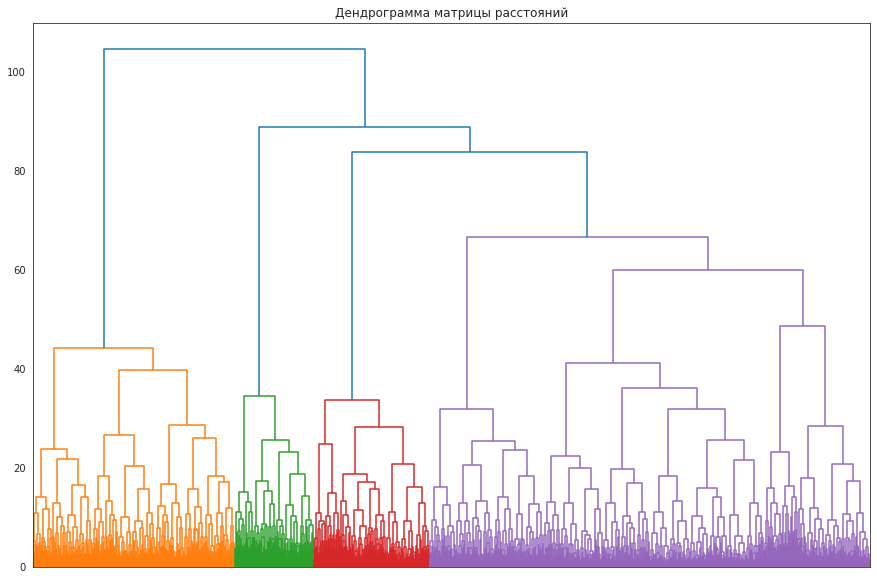

In [15]:
# построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков 
linked = linkage(x_st, method='ward')

# визуализируем linked с помощью дендрограмму
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Дендрограмма матрицы расстояний')
plt.xticks([])
plt.show()

<div class="alert alert-block alert-info">
<font color='Black'>
    
Видим, что на графике представлены области с четырьмя разными цветами, значит, что оптимальное число кластеров составляет 4. При этом стоит отметить, что область с фиолетовым цветом занимает довольно существенную часть графика.  В зависимости от расстояния между объектами, после которого мы перестаём объединять объекты, область с фиолетовым цветом можно разделить на несколько областей. Для целей нашей задачи проведем горизонтальную линию на уровне отметки немного выше 60 на вертикальной оси и, таким образом, выделим 5 кластеров.
    
Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.    
</font>
</div>

In [16]:
number_of_clusters = 5
# обучим модель кластеризации на основании алгоритма K-Means
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
clusters = kmeans.fit_predict(x_st)

# сохраняем метки кластера в поле cluster_km
data['cluster_km'] = clusters

<div class="alert alert-block alert-info">
<font color='Black'>
    
Оценим качество модели кластеризации на основании алгоритма K-Means с помощью метрика силуэта, которая показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой. Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация.
    
</font>
</div>

In [17]:
# на вход передаём стандартизованную матрицу признаков и метки, 
# которые спрогнозировал алгоритм кластеризации, в виде списка
silhouette_score(x_st, clusters) 

0.14140953623023353

<div class="alert alert-block alert-info">
<font color='Black'>
    
По значению метрики силуэта видим, что качество кластеризации не очень высокое. 
    
Проанализируем средние значения признаков для кластеров.
    
</font>
</div>

In [18]:
# выводим статистику по средним значениям признаков по кластеру
data.groupby('cluster_km').agg('mean').T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


<div class="alert alert-block alert-info">
<font color='Black'>
    
Видим, что наиболее надежными являются клиенты кластера 0 и кластера 4. Клиенты кластера 3 и кластера 2 склонны к оттоку. Клиенты кластера 1 занимают промежуточное положение. 
    
Можно выделить основные характеристики клиентов кластера 0:
- в основном проживают или работают рядом с фитнес-центром;
- большинство являются сотрудниками компаний-партнеров;
- наиболее продолжительная средняя длительность абонемента среди всех кластеров 10,9 месяцев;
- больший срок до окончания абонемента среди всех кластеров 10 месяцев; 
- среднее время с момента первого обращения в фитнес-центр 4,7 месяцев;
- средняя частота посещений в неделю около 2;
- средние траты на дополнительные услуги 161 у.е.    
    
Клиенты кластера 4 отличаются от клиентов кластера 0 по следующим признакам:
- почти в два раза меньше доля клиентов, являющихся сотрудниками компаний-партнеров, и доля клиентов по акции "приведи друга"; 
- почти в четыре раза меньше средняя длительность абонемента 2,7 месяцев;
- средняя частота посещений в неделю больше около 2,8.
 
Среди всех кластеров клиенты кластера 3 наиболее склонны к оттоку:
- они все проживают или работают рядом с фитнес-центром;  
- у них наименее продолжительная средняя длительность абонемента среди всех кластеров 1,9 месяцев;    
- средний возраст таких клиентов 28,2, это наиболее молодой кластер;    
- среднее время с момента первого обращения в фитнес-центр 2,4 месяцев, наименьшее среди всех кластеров;
- средняя частота посещений в неделю в течение последнего месяца 1,0, наименьшая среди всех кластеров.
       
Клиенты кластера 2 отличаются от клиентов кластера 3 по следующим признакам:
- не проживают/ не работают рядом с фитнес-центром;    
- имеют более продолжительную среднюю длительность абонемента 2,4 месяцев; 
- имеют более продолжительное среднее время с момента первого обращения в фитнес-центр 2,8 месяцев;
- чаще посещают фитнес-центр - средняя частота посещений в неделю больше около 1,5.  
    
Клиенты кластера 1 отличаются отсуствием контактных телефонов и довольно высокой средней длительностью абонемента 4,8 месяцев.   
    
</font>
</div>

<div class="alert alert-block alert-info">
<font color='Black'>
    
Построим графики распределения признаков для кластеров.
    
</font>
</div>

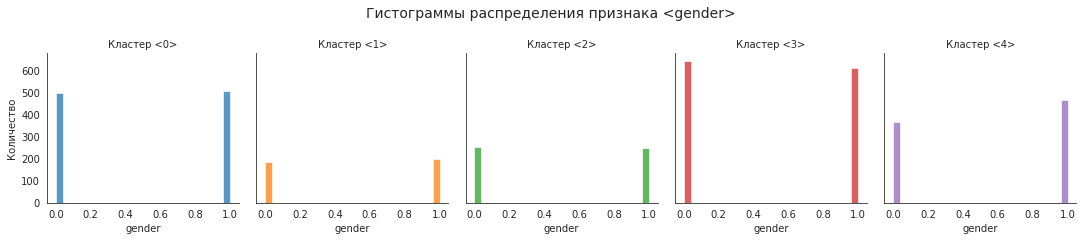

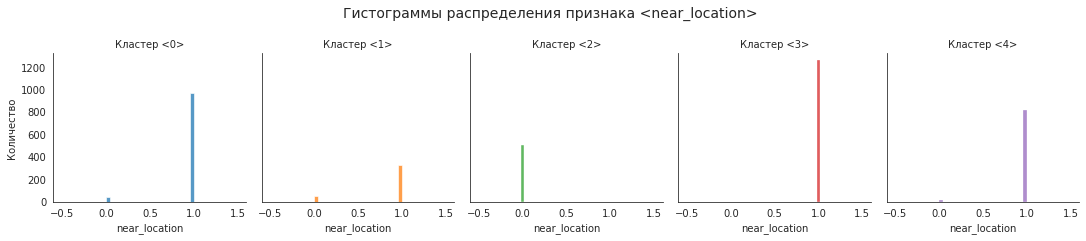

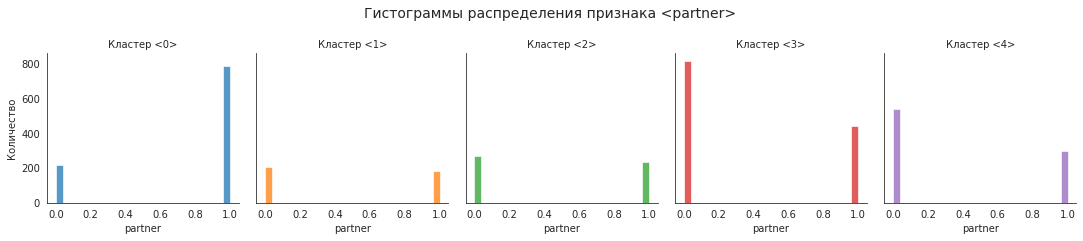

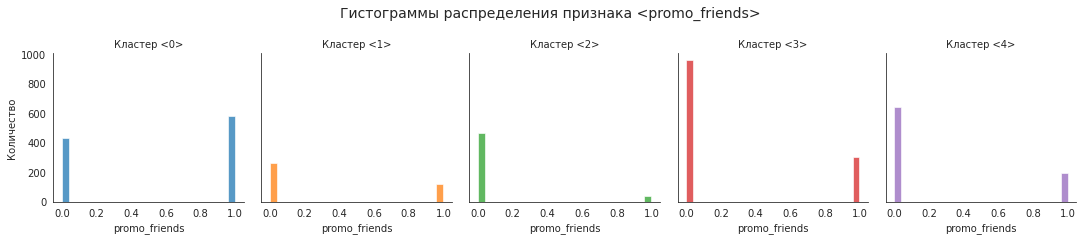

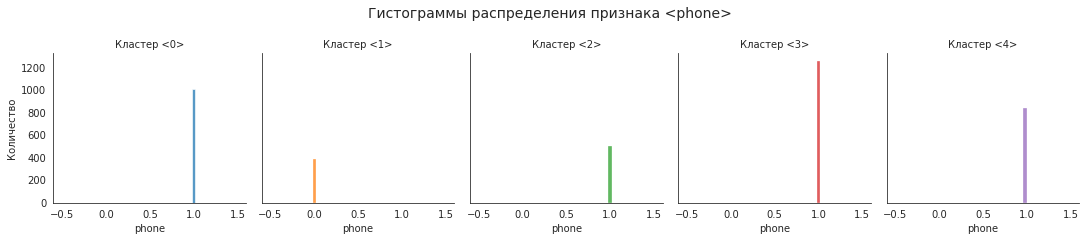

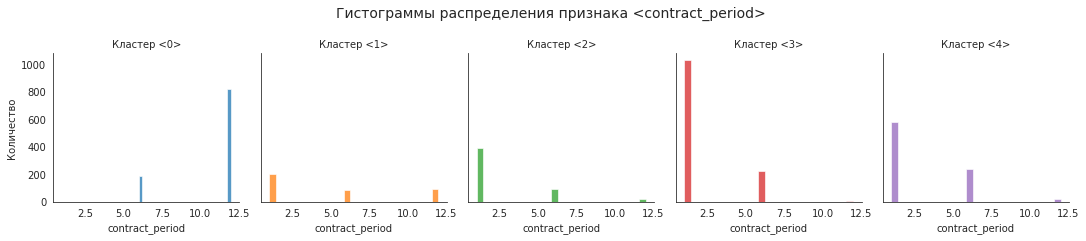

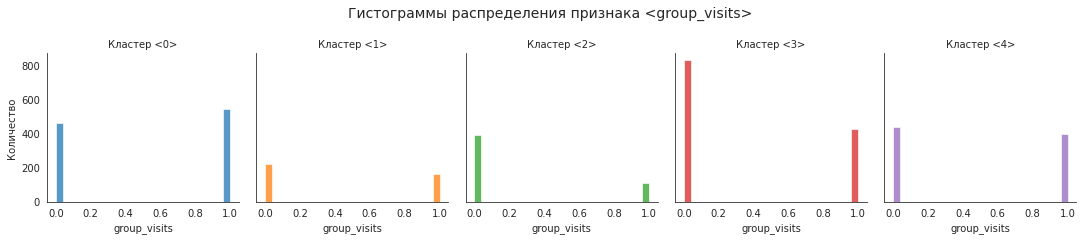

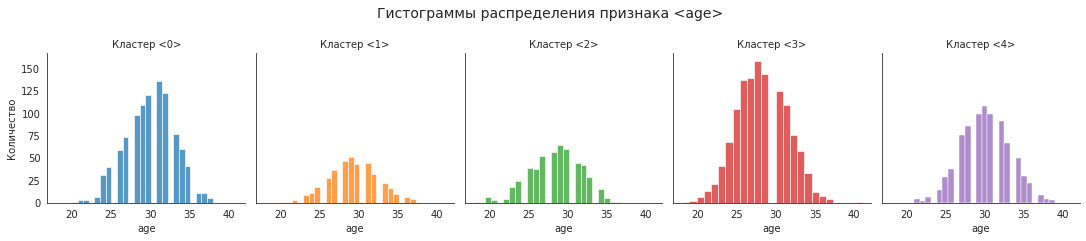

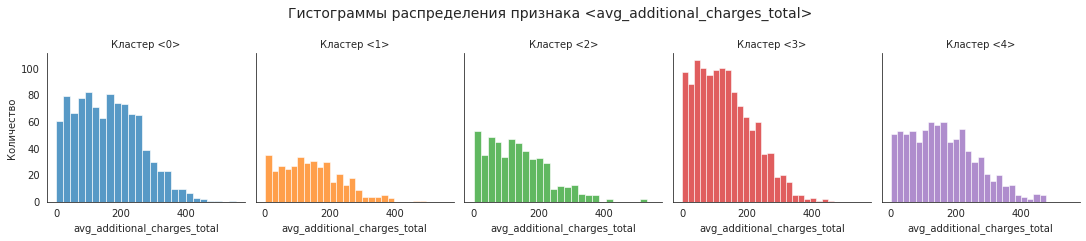

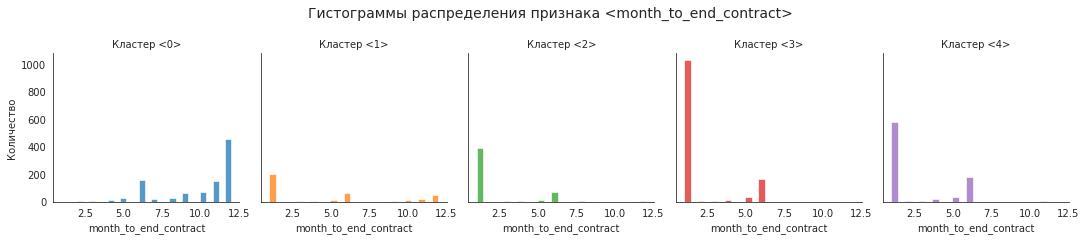

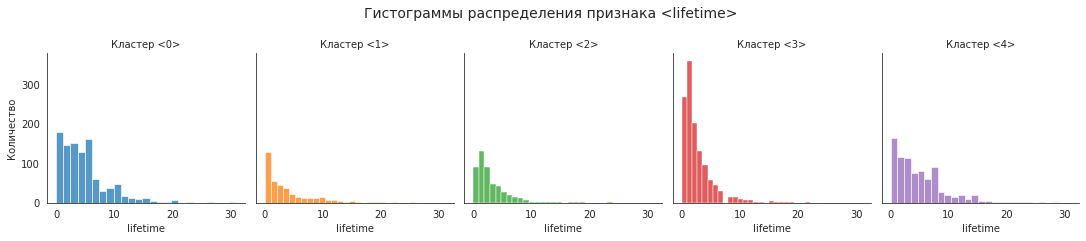

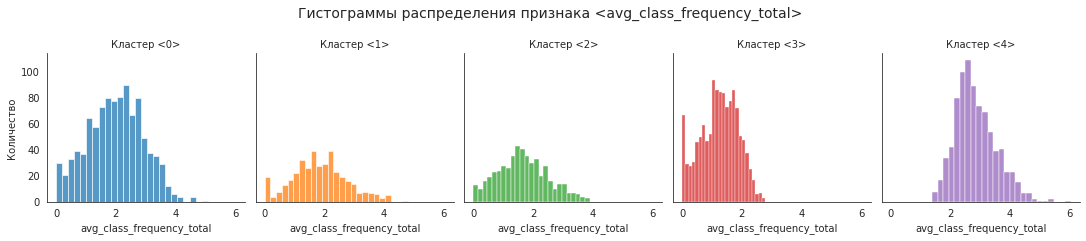

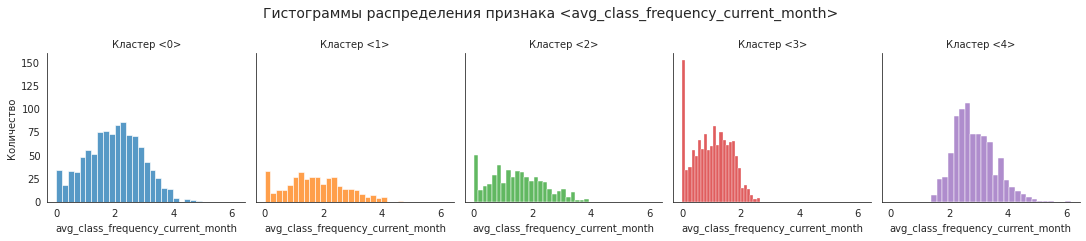

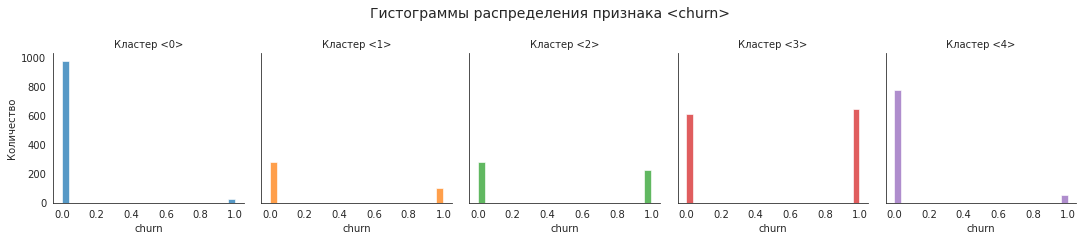

In [19]:
for feature in data.drop('cluster_km', axis=1).columns:
    grid = sns.FacetGrid(data, col='cluster_km', hue='cluster_km', col_wrap=number_of_clusters)
    grid.map(sns.histplot, feature, bins=25)
    grid.set_axis_labels(feature,'Количество')
    grid.set_titles(col_template='Кластер <{col_name}>')
    plt.suptitle('Гистограммы распределения признака <{}>'.format(feature), y=1.1, fontsize=14)

<div class="alert alert-block alert-info">
<font color='Black'>
    
На основе анализа графиков распределения признаков для кластера 3, клиенты которого наиболее склонны к оттоку, можно выделить следующие особенности:
- длительность текущего абонемента составляет 1 месяц;
- клиенты реже посещают групповые занятия;
- небольшое количество месяцев с момента первого обращения в фитнес-центр, т.е. это относительно новые клиенты.
</font>
</div>

<div style="border:solid green 3px; padding: 20px">
    
**Промежуточный вывод**
    
Наиболее надежными являются клиенты кластера 0 и кластера 4. Клиенты кластера 2 и кластера 3 склонны к оттоку. Клиенты кластера 1 занимают промежуточное положение. 
    
Среди всех кластеров клиенты кластера 3 наиболее склонны к оттоку:
- они все проживают или работают рядом с фитнес-центром;  
- преимущественно имеют минимальную длительность абонемента - 1 месяц;   
- реже посещают групповые занятия;    
- средний возраст таких клиентов 28,2, это наиболее молодой кластер;    
- среднее время с момента первого обращения в фитнес-центр 2,4 месяцев, наименьшее среди всех кластеров;
- средняя частота посещений в неделю в течение последнего месяца 1,0, наименьшая среди всех кластеров.
   
</div>

## Общие выводы и рекомендации

<div style="border:solid green 3px; padding: 20px">
    
**Общие выводы**
    
- **Краткий обзор проекта** 
    
    Провели анализ данных клиентов фитнес-центра с целью прогнозирования вероятности оттока клиентов. С помощью моделей машинного обучения для задач бинарной классификации спрогнозировали вероятность оттока (на уровне следующего месяца) для каждого клиента; с помощью моделей машинного обучения для задач кластерезации сформировали типичные портреты клиентов; проанализировали основные признаки, наиболее сильно влияющие на отток.
    
    
- **Главные выводы** 
    
    
   1. Для прогнозирования вероятности оттока клиентов можно использовать модель логистической регрессии, так как она показала более лучшие значения метрик.
    
    
   2. С помощью алгоритма K-Means для кластерезации выделили кластер, клиенты которого наиболее склонны к оттоку. Для данных клиентов характерно следующее: 
    
    - они все проживают или работают рядом с фитнес-центром;  
    - преимущественно имеют минимальную длительность абонемента - 1 месяц;   
    - реже посещают групповые занятия;    
    - средний возраст таких клиентов 28,2 лет, это наиболее молодой кластер;    
    - среднее время с момента первого обращения в фитнес-центр 2,4 месяцев, наименьшее среди всех кластеров;
    - средняя частота посещений в неделю в течение последнего месяца 1,0, наименьшая среди всех кластеров.
   
    
   3. Выявили признаки наиболее влияющие на отток, такие как длительность абонемента, время с момента первого обращения, факт посещения групповых занятий, частота посещений в неделю за последний месяц. Короткая длительность абонемента, небольшое время с момента первого обращения, отсутствие посещения групповых занятий и редкая частота посещений в неделю за последний месяц способствуют оттоку клиента.
    
    
- **Рекомендации**
    
   1) Рекомендуется проводить промоакции для новых клиентов при оформлении абонемента длительностью от 6 месяцев, предлагать скидки или бонусы.
    
   2) По возможности проводить мониторинг посещаемости фитнес-центра один раз в неделю, в случаях значимого снижения показателя посещаемости предлагать клиентам различного вида бонусы с помощью смс-уведомлений (например, скидки на дополнительные услуги).
    
   3) Рекомендуется стимулировать клиентов к посещению групповых занятий, предлагая разовые бесплатные посещения таких занятий.
    
   4) Рекомендуется проводить опросы клиентов с целью определения степени удовлетворенности услугами, возможно потребуется внедрение новых дополнительных услуг.
    
</div>